# Introduction

You all know word clouds:
    
They give you a quick overview about the top topics of your blog, book, source code &ndash; or presentation. The latter was the one that got me thinking: How cool would it be if you start your presentation with a word cloud of the main topics of your talk? And: How easy is it to do that completely automated with Python?!

So let's go crazy this time with word cloud computing for different data sources like texts, source code, websites and PowerPoint presentations!

# The Idea
The main idea is to read any text in any format, preprocess it and throw it against a word cloud producting library. For this, we need some main libraries that do all the work for us:

* <tt>wordcloud</tt> for producing, well, a word cloud
* <tt>nltk</tt> for cleaning up our input text
<!--* <tt>matplotlib</tt> for visualizing the word cloud-->

\+ I'll introduce some other libraries as needed.


So let's get started!

# Basics
In this section, I demonstrate how easy it is to produce a word cloud out of some given text with <tt>wordcloud</tt>.

The following code is almost identical to the example of the libaries' website:

We import the <tt>WordCloud</tt> class, enable the <tt>matplotlib</tt> output in our notebook and import the plot library itself.

Then we get an instance of <tt>WordCloud</tt> and use it directly to generate a wordcloud

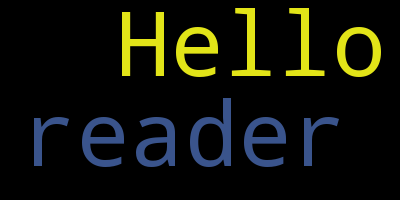

In [12]:
from wordcloud import WordCloud

WordCloud().generate("Hello reader!").to_image()

In [ ]:
That's it!

In [7]:
def produce_wordcloud(text):
    wordcloud = WordCloud(max_font_size=40).generate(text)
    wordcloud.to_image()
    #plt.figure()
    #plt.imshow(wordcloud, interpolation="bilinear")
    #plt.axis("off")
    #plt.show()

# Advanced
The example above wasn't very impressive and expressive. So we use <tt>nltk</tt> for getting some texts from a corpus. We want to display the main topics of move reviews. For this, we need some basic text preprocessing: removing the language's common words via a stoplist for that language. The stoplist is just a corpus, too, and is just a list of text tokens.

In [8]:
from nltk.corpus import stopwords
english_stopword_tokens = stopwords.words('english')
english_stopword_tokens[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

OK, let's get some big texts.

In [ ]:
from nltk.corpus import movie_reviews
movie_reviews.words()[:10]

Let's do some basic text preprocessing by only keeping alphanumeric characters and removing the stopwords.

In [ ]:
movie_reviews_tokens = [s for s in movie_reviews.words() 
                        if s.isalnum() and 
                        not s in english_stopword_tokens]
movie_reviews_tokens[:10]

We join the text together to get a long string and display it as word cloud.

In [ ]:
movie_reviews_text = " ".join(movie_reviews_tokens)
WordCloud(max_font_size=40).generate(movie_reviews_text).to_image()
#produce_wordcloud(movie_reviews_text)

In [ ]:
WordCloud(max_font_size=40).generate(movie_reviews_text).to_image

Let's move on to some more interesting visualizations.

# Some real project

We can read arbitrary files with <tt>glob</tt>

In [ ]:
import os
from glob import glob

def read_file_paths(directory, filename_extensions, non_relevant_paths=[]):
    
    source_code_filenames =[]
    
    for root, directories, filenames in os.walk(directory):
        for filename in filenames:
            if os.path.splitext(filename)[1].lower() in filename_extensions:
                path = os.path.join(root,filename).replace("\\", "/")
                if not any(non_dir in path for non_dir in non_relevant_paths):
                    source_code_filenames.append(path)
                    
    return source_code_filenames

file_paths = read_file_paths(
                            r'../../aim42/', 
                            [".adoc"], 
                            [".git"])
file_paths[:5]

In [ ]:
import pandas as pd
docs_corpus = []

for file_path in file_paths:
    with open(file_path, mode='r', encoding="utf-8") as file:
        docs_corpus.append(file.read())
docs_corpus[0][:100]

In [ ]:
docs_tokens = docs_corpus
docs_tokens[:100]

In [ ]:
docs_tokens = [s for s in docs_corpus.split[" "] 
                if s.isalnum() and 
                not s in english_stopword_tokens]
docs_tokens[:100]

# Source Code identifier

It's nice to get a quick gimplse what your software is about. For this, we need to read all the source code files, extract the identifiers, handle some programming language specific cases and remove common words via the stop list.

## Reading all the source code files

I wrote a small library to handle all the repeating tasks called OZAPFT (**O**pen **z**appy **a**nalysis **p**latform **f**or **t**echies)

In [24]:
from ozapft import FileReader
filereader = FileReader()


TypeError: 'module' object is not callable

In [15]:
import os
from glob import glob
 
SOURCE_CODE_DIRECTORY = r'../../spring-petclinic/'
source_code_filenames =[]


ImportError: cannot import name 'Filereader'

# PowerPoint Presentation

In [ ]:
from pptx import Presentation
PPTX = r'C:\Users\Markus\OneDrive\Vorträge\Software Analytics\talk.pptx'
prs = Presentation(PPTX)

text_fragments = []
for slide in prs.slides:
    
    title = ""
    if slide.shapes.title and slide.shapes.title.text:
        title = slide.shapes.title.text
     
    if slide.has_notes_slide:
        notes = slide.notes_slide.notes_text_frame.text
        text_fragments.extend(s for s in notes.split(" ") if s.isalnum())
    for shape in slide.shapes:
        if not shape.has_text_frame:
            continue
        
        text_frame_text = shape.text_frame.text.replace(title, "")
        text_frame_tokens = text_frame_text.split(" ")
        text_fragments.extend(s for s in text_frame_tokens if s.isalnum())
        
text_fragments[:10]

In [ ]:
from nltk.corpus import stopwords
german_stopword_tokens = stopwords.words('german')
german_stopword_tokens.append("Nichts")
stop_word_tokens = set(german_stopword_tokens) | set(english_stopword_tokens)
text_tokens = [token for token in text_fragments if token not in stop_word_tokens]
text_tokens[:10]

In [ ]:
text = " ".join(text_tokens)
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()